# CAUSAL INFERENCE

In [2]:
#Data Cleaning
import numpy as np
import pandas as pd

# Random Forests, Decison Trees and Boosting methods
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier 

#Hyperparametes Tuning
from sklearn.model_selection import cross_val_score
import optuna
import pickle

#For buiding DNN
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Estimation
from scipy.stats import norm

#extra
import timeit

In [3]:
df = pd.read_csv('Cleaned_2018.csv')
df.drop('Unnamed: 0', axis = 1, inplace= True)


parents = [col for col in df.columns if col.endswith('_pa') or col.startswith('ch_')]
pvs = [col for col in df.columns if col.startswith('pv')]
weights = [col for col in df.columns if col.startswith('w_')]
not_controls  = ['g', 'cnt', 'cntschid', 'cntstuid', 'progn']  + pvs + weights
covariates = sorted([col for col in df.columns if col not in parents and col not in not_controls])

rep_weights = weights
rep_weights.remove('w_fstuwt')

print(covariates)

['age_elementary', 'clsize', 'cntryid', 'cultposs', 'hedres', 'heduc', 'hisei', 'homepos', 'ictres', 'immig', 'lmins', 'male', 'mmins', 'oecd', 'prop_disadv', 'propqual', 'repeat', 'schsize', 'smins', 'stratio', 'wealth']


In [4]:
def train_test(model, X, y, size=0.2, state=46):
    '''
    A function that splits the data into trainin and test according to the specified parameters
    Size corresponds to the share of total data asssigned to the test dataset, default 0.2
    State corresponds to the replication seed used to perform the split
    
    Accuracy score, confusion matrix and runtime are returned.
    '''
    
    start = timeit.default_timer()

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=state)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    stop = timeit.default_timer()
    runtime=round((stop-start),3)
    
    print(f'''
    model = {model}
accuracy = {round(accuracy_score(y_true=y_test, y_pred=pred),3)}
confusion matrix: 
{confusion_matrix(y_true=y_test, y_pred=pred)}
''')
    print('Runtime(seconds): ', runtime) 
    
    return round(accuracy_score(y_true=y_test, y_pred=pred),3) , confusion_matrix(y_true=y_test, y_pred=pred), runtime


# Functions

### Matching function 

In [5]:
def PSMatch(df, treatment, propensity_score, weights=None, caliper_width=None):
    # Create copies of dataframes for treatment and control groups
    control_group = df[df[treatment] == 0].copy()
    treatment_group = df[df[treatment] == 1].copy()

    #possibility of weighting   
    if weights is None:
        # Nearest Neighbours on control group
        nn = NearestNeighbors(n_neighbors=1).fit(np.array(control_group[propensity_score]).reshape(-1, 1))
        # Find nearest neighbor in control group for each individual in treatment group
        distances, indices = nn.kneighbors(np.array(treatment_group[propensity_score]).reshape(-1, 1))
    else:
        nn = NearestNeighbors(n_neighbors=1).fit(np.array(control_group[propensity_score] / np.array(control_group[weights])).reshape(-1, 1))
        distances, indices = nn.kneighbors(np.array(treatment_group[propensity_score] / np.array(treatment_group[weights])).reshape(-1, 1))
    
    #Possibility of using caliper matching 
    if caliper_width is not None:
        indices = indices[distances.flatten() <= caliper_width]    
        
    # Add 'match' column to treatment group
    treatment_group = treatment_group.assign(match=np.arange(len(treatment_group)))

    # Add 'match' column to control group
    control_group = control_group.assign(match=np.nan)  # Initialize 'match' column with NaN values
    control_group.loc[control_group.index[indices.flatten()], 'match'] = treatment_group['match'].values

    # Combine the matched individuals from treatment and control groups into a new DataFrame
    matched_df = pd.concat([treatment_group.dropna(subset=['match']), control_group.dropna(subset=['match'])])
   
    return matched_df


### Covariates Balance Assesment Functions 

In [6]:
def PSPlot(df, treatment, propensity_score):
    '''
    Function to plot density of propensity score among treatment and control groups
    '''    
    treatment_group = df[df[treatment] == 1]
    control_group = df[df[treatment] == 0]
    
    sns.displot(data=df, x=propensity_score, hue=treatment, kind='hist')
    plt.xlabel('Propensity Score')
    plt.ylabel('Count')
    plt.show()


In [7]:
def SMD(df, treatment, covariates_list, weight=None):
    '''
    Function to compute absolute Cohen's d or absolute standardized mean difference, values of d below 0.2 are considered small effect sizes, sign of good balancing
    '''
    treatment_group = df[df[treatment] == 1]
    control_group = df[df[treatment] == 0]
    
    smd_dict = {}  
    
    for var in covariates_list:
        if weight is not None:
            mean_treatment = np.average(treatment_group[var], weights=treatment_group[weight])
            mean_control = np.average(control_group[var], weights=control_group[weight])
            std_treatment = np.sqrt(np.average((treatment_group[var]-mean_treatment)**2, weights=treatment_group[weight]))
            std_control = np.sqrt(np.average((control_group[var]-mean_control)**2, weights=control_group[weight]))
        else:
            mean_treatment = treatment_group[var].mean()
            mean_control = control_group[var].mean()
            std_treatment = treatment_group[var].std()
            std_control = control_group[var].std()

        pooled_std = np.sqrt((std_treatment**2 + std_control**2) / 2)

        smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
        
        smd_dict[var] = smd  
        
    return smd_dict  # Return the dictionary containing the SMD for each variable


In [8]:
def VR(df, treatment, covariates_list, weight=None):
    '''
    Function to compute Variance Ratio between treatment and control groups, values close to 1 are considered sign of good balancing
    '''
    treatment_group = df[df[treatment] == 1]
    control_group = df[df[treatment] == 0]
    
    vr_dict = {}  # Initialize an empty dictionary to store the variance ratio for each variable
    
    for var in covariates_list:
        if weight is not None:
            var_treatment = np.average((treatment_group[var]-treatment_group[var].mean())**2, weights=treatment_group[weight])
            var_control = np.average((control_group[var]-control_group[var].mean())**2, weights=control_group[weight])
        else:
            var_treatment = treatment_group[var].var()
            var_control = control_group[var].var()
        
        variance_ratio = round((var_treatment / var_control),3)
        
        vr_dict[var] = variance_ratio  # Store the variance ratio for the current variable in the dictionary

    return vr_dict  # Return the dictionary containing the variance ratio for each variable


In [9]:
def AssessBalance(df, matched_boost, treatment, covariates, weights=None):
    '''
    Function compute easily VR and SMD and display nicely results to allow comparisons
    '''
    
    df_stats = pd.DataFrame()
    
    if weights is not None:
        SMDpreW = SMD(df, treatment, covariates, weight=weights)
        SMDpostW = SMD(matched_boost, treatment, covariates, weight=weights)
        VRpreW = VR(df, treatment, covariates, weight=weights)
        VRpostW = VR(matched_boost, treatment, covariates, weight=weights)

        df_stats['variables'] = SMDpreW.keys()
        df_stats['SMDpreW'] = SMDpreW.values()
        df_stats['SMDpostW'] = SMDpostW.values()
        df_stats['VRpreW'] = VRpreW.values()
        df_stats['VRpostW'] = VRpostW.values()   
        
       
    else:        
        SMDpre = SMD(df, treatment, covariates)
        SMDpost = SMD(matched_boost, treatment, covariates)
        VRpre = VR(df, treatment, covariates)
        VRpost = VR(matched_boost, treatment, covariates)

        df_stats['variables'] = SMDpre.keys()
        df_stats['SMDpre'] = SMDpre.values()
        df_stats['SMDpost'] = SMDpost.values()
        df_stats['VRpre'] = VRpre.values()
        df_stats['VRpost'] = VRpost.values()
       
    last = len(covariates)
    return df_stats.iloc[0:last]


### Estimation Functions

In [10]:
def MeanComparison(df, pv, group_col, weight_col=None):
    '''
    Function to easily compute mean comparisons, supports weights
    '''
    control_group = df[df[group_col] == 0]
    treatment_group = df[df[group_col] == 1]

    if weight_col is None:
        mean_control = control_group[pv].mean()
        mean_treatment = treatment_group[pv].mean()
    else:
        mean_control = np.average(control_group[pv], weights=control_group[weight_col])
        mean_treatment = np.average(treatment_group[pv], weights=treatment_group[weight_col])
    
    effect = mean_treatment - mean_control
    return effect

In [11]:
def PisaEstimate(df, pv_columns, rep_weight_columns, final_weight_col, group_col, compute_effect):
    '''
    Function to easily compute accurate coefficients and standard errors using PISA replicatiion weights.
    Built following the instructions provided in Chapter 8 of the "PISA Data Analysis Manual SAS® SECOND EDITION" (OECD, 2009),
    available at: https://www.oecd.org/pisa/pisaproducts/pisadataanalysismanualspssandsassecondedition.htm
    '''
    
    M = len(pv_columns) 

    effects = []
    sampling_variances = []

    # Step 1: Compute the effect for each PV
    for pv in pv_columns:
        # Compute the effect for each PV using the final weight
        effect = compute_effect(df, pv, group_col, final_weight_col)
        effects.append(effect)

        # Compute sampling variance for the effect using the replicate weights
        replicate_effects = [
            compute_effect(df, pv, group_col, weight_col)
            for weight_col in rep_weight_columns
        ]
        
        sampling_variance = np.var(replicate_effects, ddof=1)
        sampling_variances.append(sampling_variance)

    # Step 2: Final estimate (mean of the effects for each PV)
    final_effect = np.mean(effects)

    # Step 3: Final sampling variance (mean of sampling variances for each PV)
    final_sampling_variance = np.mean(sampling_variances)

    # Step 4: Measurement error/imputation variance
    imputation_variance = (1 / (M - 1)) * np.sum((np.array(effects) - final_effect) ** 2)

    # Step 5: Final error variance
    final_error_variance = final_sampling_variance + (1 + 1 / M) * imputation_variance

    # Step 6: Standard Error (S.E.)
    standard_error = np.sqrt(final_error_variance)
    
    # Extra, Compute P-Value 
    p_value = 2 * (1 - norm.cdf(abs(final_effect/standard_error)))
    if p_value <= 0000.1:
        p_value = 0.0
    
    print(f'Estimate: {round(final_effect,3)}, Standard Error: {round(standard_error,3)}, p-value: {p_value}')
    
    return final_effect, standard_error, p_value

# Preprocessing

In [12]:
scaler = StandardScaler()

for pv in pvs:
    # Convert to numeric, coercing errors to NaN
    df[pv] = pd.to_numeric(df[pv], errors='coerce')   
    
    # Fit and transform the scaler
    df['z_' + pv] = scaler.fit_transform(df[[pv]])

standardized_vals = [col for col in df.columns if col.startswith('z_')]
not_controls = not_controls + standardized_vals

pv_math = [col for col in df[standardized_vals].columns if col.endswith('math')]
pv_scie = [col for col in df[standardized_vals].columns if col.endswith('scie')]
pv_read = [col for col in df[standardized_vals].columns if col.endswith('read')]

dfa = df.copy(deep=True)

In [13]:
#Prepare the models
#LOGISTIC
lr = LogisticRegression(max_iter=10000)
train_test(lr, df[covariates], df['g'])


    model = LogisticRegression(max_iter=10000)
accuracy = 0.729
confusion matrix: 
[[3477 1931]
 [1377 5415]]

Runtime(seconds):  19.472


(0.729,
 array([[3477, 1931],
        [1377, 5415]]),
 19.472)

In [14]:
#XGBOOST
xgboost = XGBClassifier(n_estimators=500, learning_rate=0.26, max_depth=7, random_state=46)
train_test(xgboost, df[covariates], df['g'])


    model = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.26, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=46, ...)
accuracy = 0.975
confusion matrix: 
[[5216  192]
 [ 110 6682]]

Runtime(seconds):  1.315


(0.975,
 array([[5216,  192],
        [ 110, 6682]]),
 1.315)

In [15]:
#DNN
X_train, X_test, y_train, y_test = train_test_split(df[covariates], df['g'], test_size=0.2, random_state=46)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train) # determine min and max
X_train = min_max_scaler.transform(X_train) #Train normalized
X_test = min_max_scaler.transform(X_test) #Test normalized


DNNmodel = tf.keras.Sequential()
DNNmodel.add(layers.Dense(236, activation='relu', kernel_initializer=initializers.get('glorot_uniform')))
DNNmodel.add(layers.Dropout(rate=0.1))
DNNmodel.add(layers.Dense(1, activation='sigmoid', kernel_initializer=initializers.get('glorot_uniform')))

DNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001)

DNNmodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=93, batch_size=128,verbose=0)  

# Estimate Propensity Score

In [16]:
#Obtain propensity scores from the models
df['ps_lr'] = lr.predict_proba(df[covariates])[:,1]
df['ps_boost'] = xgboost.predict_proba(df[covariates])[:, 1]
df['ps_DNN'] = DNNmodel.predict(df[covariates])

1907/1907 [==============================] - 2s 782us/step


# Matching

In [17]:
matched_lr = PSMatch(df, 'g', 'ps_lr')
matched_boost = PSMatch(df, 'g', 'ps_boost')
matched_DNN = PSMatch(df,'g','ps_DNN')

In [18]:
print(matched_lr.shape)
print(matched_boost.shape)
print(matched_DNN.shape)

for data in [matched_lr, matched_boost, matched_DNN]:
    print(data['g'].value_counts())

(46142, 189)
(34396, 189)
(34286, 189)
1.0    34139
0.0    12003
Name: g, dtype: int64
1.0    34139
0.0      257
Name: g, dtype: int64
1.0    34139
0.0      147
Name: g, dtype: int64


# Covariate Balance Assesment
Covariate Balance assesment is the process of testing how well the propensity score is able to equalize the weight of covariates among treatment and control groups

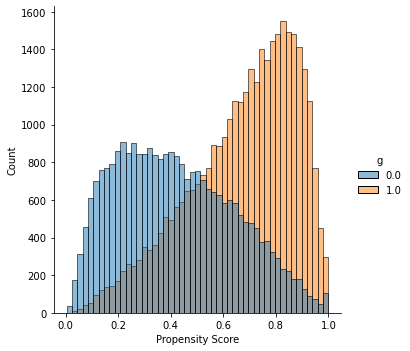

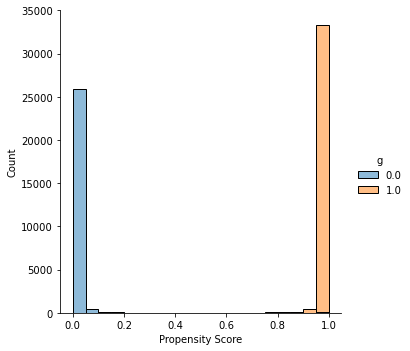

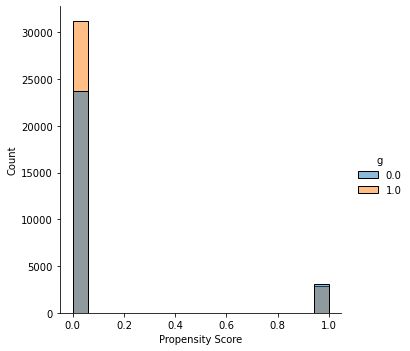

In [19]:
PSPlot(df,'g', 'ps_lr')

PSPlot(df, 'g', 'ps_boost')

PSPlot(df, 'g', 'ps_DNN')

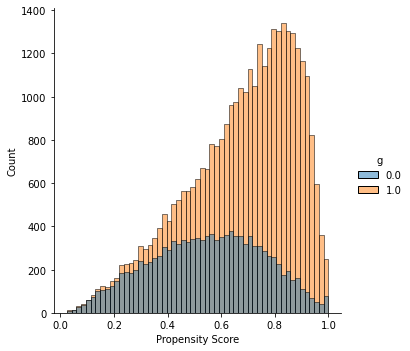

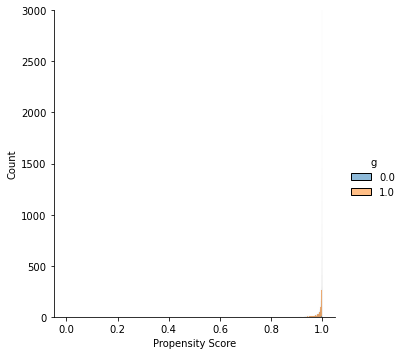

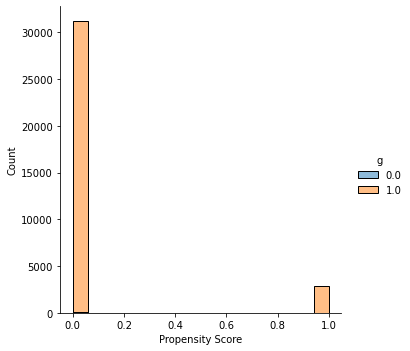

In [20]:
PSPlot(matched_lr, 'g', 'ps_lr')

t = matched_boost[matched_boost['g'] == 1]
c = matched_boost[matched_boost['g'] == 0]
sns.displot(data=matched_boost, x='ps_boost', hue='g', kind='hist')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.ylim(0, 3000) 
plt.show()

PSPlot(matched_DNN, 'g', 'ps_DNN')


In [21]:
print('LOGISTIC REGRESSION')
AssessBalance(df, matched_lr, 'g', covariates)

LOGISTIC REGRESSION


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.011,0.993,1.000
1,clsize,0.255,0.082,1.126,0.932
2,cntryid,0.290,0.080,0.947,0.956
3,cultposs,0.348,0.193,1.188,1.108
4,hedres,0.199,0.099,0.868,0.924
5,heduc,0.297,0.200,1.077,1.059
6,hisei,0.511,0.291,1.207,1.107
7,homepos,0.393,0.223,1.100,1.059
8,ictres,0.225,0.137,1.032,1.025
9,immig,0.008,0.007,0.991,0.968


In [22]:
print('XGBOOST')
AssessBalance(df, matched_boost, 'g', covariates)

XGBOOST


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.018,0.993,0.751
1,clsize,0.255,0.163,1.126,1.100
2,cntryid,0.290,0.142,0.947,0.885
3,cultposs,0.348,0.350,1.188,1.075
4,hedres,0.199,0.285,0.868,0.802
5,heduc,0.297,0.224,1.077,0.834
6,hisei,0.511,0.302,1.207,1.003
7,homepos,0.393,0.321,1.100,0.848
8,ictres,0.225,0.216,1.032,0.908
9,immig,0.008,0.051,0.991,1.279


In [23]:
print('DNN')
AssessBalance(df, matched_DNN, 'g', covariates)

DNN


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.237,0.993,1.102
1,clsize,0.255,0.317,1.126,1.814
2,cntryid,0.290,0.667,0.947,0.896
3,cultposs,0.348,0.412,1.188,1.455
4,hedres,0.199,0.213,0.868,0.935
5,heduc,0.297,0.407,1.077,1.122
6,hisei,0.511,0.533,1.207,1.285
7,homepos,0.393,0.542,1.100,1.208
8,ictres,0.225,0.359,1.032,0.916
9,immig,0.008,0.054,0.991,1.079


# Comments
Balancing Works!
Ideally post matching you would like to have:
- Values of Cohens'd below 0.2 (treshold usually employed to divide variables between inpactful or not)
- Values of Variance ratio close to one, this is because a value close to one implies similar variance of the variable across treatment and conntrol groups

The comparison of propensity scores estimation seems to suggest logistic regression to be the best instrument of balance.
I will conduct analysis based on logistic regression matched data. 


# Estimation
I will estimate effects using propensity scores computed via logistic regression. In order to obtain the estimated treatment effect I will compute the difference in mean among treated and non treated individuals belonging to the dataset of matched pairs.

Given the complexity related to the survey structure of the PISA dataset in order to achieve statistically reliable results I have to compute each measure for all the potential outcome variables as each student is assigned 10 plausible values of the test grade drawn from a distribution centered around the true test result and accurate standard error must be computed adopting the 80 replications weights provided for each student. To ease readability of the noteboook I have created a function to compute accurate mean differences and anotherone to compute accurate standard errors. The latter function takes the former as argument, that's why you only see one command in the below cells.

In [147]:
PisaEstimate(matched_lr, pv_math, rep_weights, 'w_fstuwt', 'g', MeanComparison)

Estimate: 0.729, Standard Error: 0.018, p-value: 0.0


(0.72896846283517, 0.01776402435103762, 0.0)

In [148]:
PisaEstimate(matched_lr, pv_scie, rep_weights, 'w_fstuwt', 'g', MeanComparison)

Estimate: 0.734, Standard Error: 0.016, p-value: 0.0


(0.734136131975964, 0.016420483976904224, 0.0)

In [149]:
PisaEstimate(matched_lr, pv_read, rep_weights, 'w_fstuwt', 'g', MeanComparison)

Estimate: 0.746, Standard Error: 0.015, p-value: 0.0


(0.7459263947903022, 0.015059034594549082, 0.0)

In [150]:
print(dfa['cnt'].unique())

['ALB' 'BEL' 'BGR' 'BIH' 'CHE' 'CZE' 'FRA' 'GRC' 'HRV' 'HUN' 'ITA' 'LTU'
 'LUX' 'MNE' 'PRT' 'ROU' 'SRB' 'SVK' 'SVN' 'TUR']


-------------------------------
ALB
-------------------------------
(78, 187)
Total number of observations: 78, of which 39 treated and 39 are controls


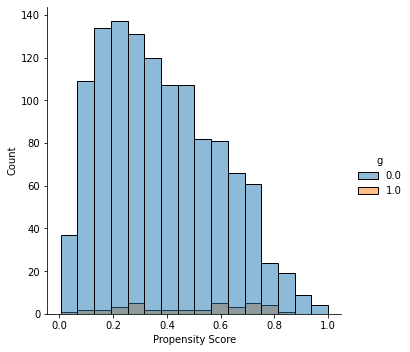

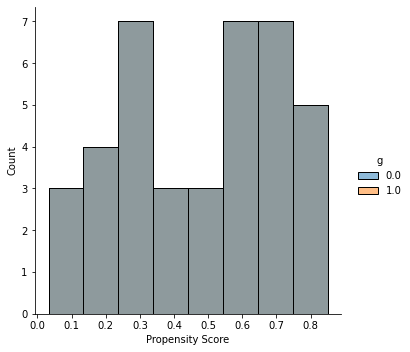

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.192,0.993,0.703
1,clsize,0.255,0.852,1.126,3.240
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.692,1.188,1.683
4,hedres,0.199,0.538,0.868,0.650
5,heduc,0.297,0.694,1.077,0.605
6,hisei,0.511,0.765,1.207,0.653
7,homepos,0.393,0.713,1.100,0.717
8,ictres,0.225,0.438,1.032,0.597
9,immig,0.008,0.132,0.991,0.514


ALB  MATH
Estimate: 0.683, Standard Error: 0.222, p-value: 0.0
ALB  SCIENCE
Estimate: 0.768, Standard Error: 0.155, p-value: 0.0
ALB  READING
Estimate: 0.858, Standard Error: 0.15, p-value: 0.0
-------------------------------
BEL
-------------------------------
(3645, 187)
Total number of observations: 3645, of which 2930 treated and 715 are controls


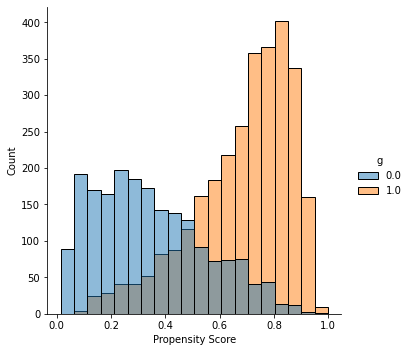

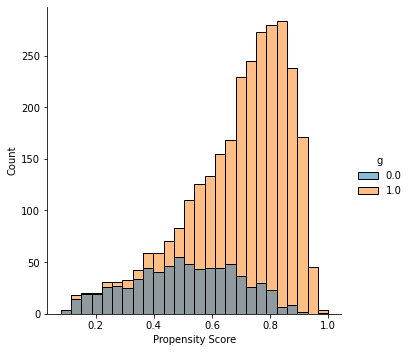

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.122,0.993,0.639
1,clsize,0.255,0.965,1.126,0.929
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.195,1.188,0.946
4,hedres,0.199,0.045,0.868,0.984
5,heduc,0.297,0.239,1.077,0.889
6,hisei,0.511,0.258,1.207,0.953
7,homepos,0.393,0.110,1.100,1.026
8,ictres,0.225,0.098,1.032,0.925
9,immig,0.008,0.059,0.991,1.053


BEL  MATH
Estimate: 0.774, Standard Error: 0.034, p-value: 0.0
BEL  SCIENCE
Estimate: 0.765, Standard Error: 0.032, p-value: 0.0
BEL  READING
Estimate: 0.817, Standard Error: 0.028, p-value: 0.0
-------------------------------
BGR
-------------------------------
(1568, 187)
Total number of observations: 1568, of which 1150 treated and 418 are controls


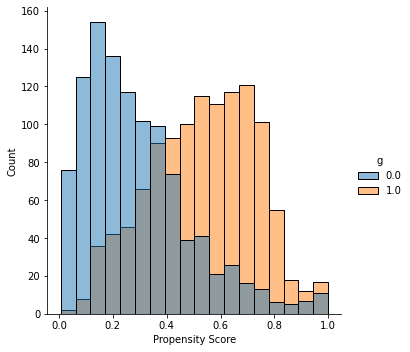

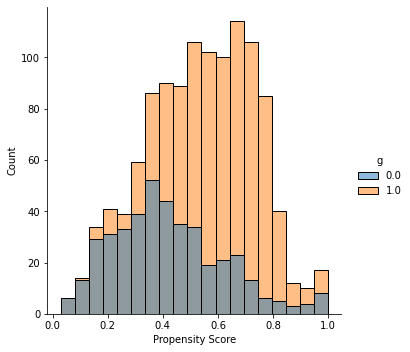

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.138,0.993,0.779
1,clsize,0.255,0.305,1.126,1.686
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.157,1.188,1.032
4,hedres,0.199,0.106,0.868,0.761
5,heduc,0.297,0.200,1.077,0.897
6,hisei,0.511,0.167,1.207,1.043
7,homepos,0.393,0.125,1.100,0.723
8,ictres,0.225,0.059,1.032,0.767
9,immig,0.008,0.054,0.991,3.624


BGR  MATH
Estimate: 0.431, Standard Error: 0.064, p-value: 0.0
BGR  SCIENCE
Estimate: 0.569, Standard Error: 0.053, p-value: 0.0
BGR  READING
Estimate: 0.665, Standard Error: 0.05, p-value: 0.0
-------------------------------
BIH
-------------------------------
(966, 187)
Total number of observations: 966, of which 555 treated and 411 are controls


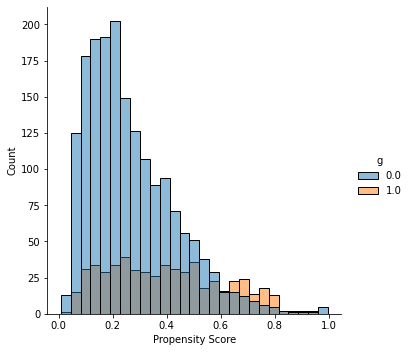

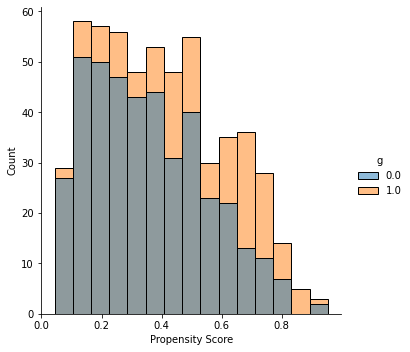

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.100,0.993,0.792
1,clsize,0.255,0.429,1.126,0.663
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.299,1.188,1.098
4,hedres,0.199,0.263,0.868,0.938
5,heduc,0.297,0.239,1.077,1.020
6,hisei,0.511,0.263,1.207,1.105
7,homepos,0.393,0.319,1.100,0.918
8,ictres,0.225,0.210,1.032,0.951
9,immig,0.008,0.130,0.991,0.486


BIH  MATH
Estimate: 0.669, Standard Error: 0.055, p-value: 0.0
BIH  SCIENCE
Estimate: 0.666, Standard Error: 0.049, p-value: 0.0
BIH  READING
Estimate: 0.723, Standard Error: 0.042, p-value: 0.0
-------------------------------
CHE
-------------------------------
(2430, 187)
Total number of observations: 2430, of which 2082 treated and 348 are controls


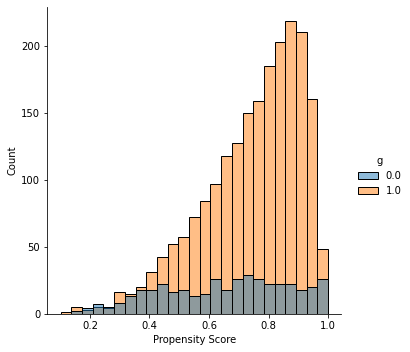

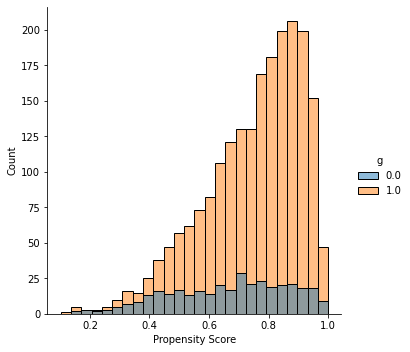

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.509,0.993,1.405
1,clsize,0.255,0.171,1.126,0.295
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.126,1.188,1.112
4,hedres,0.199,0.138,0.868,1.148
5,heduc,0.297,0.040,1.077,1.490
6,hisei,0.511,0.012,1.207,1.164
7,homepos,0.393,0.065,1.100,1.552
8,ictres,0.225,0.066,1.032,1.449
9,immig,0.008,0.195,0.991,1.286


CHE  MATH
Estimate: -0.323, Standard Error: 0.053, p-value: 0.0
CHE  SCIENCE
Estimate: -0.319, Standard Error: 0.05, p-value: 0.0
CHE  READING
Estimate: -0.238, Standard Error: 0.041, p-value: 0.0
-------------------------------
CZE
-------------------------------
(1269, 187)
Total number of observations: 1269, of which 930 treated and 339 are controls


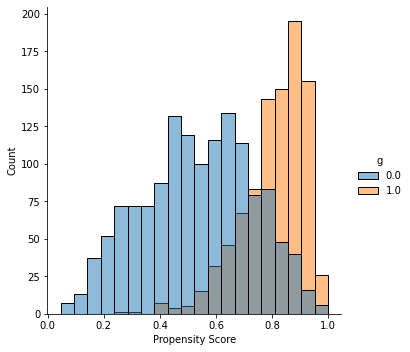

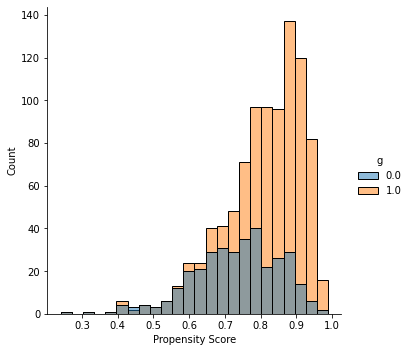

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.268,0.993,0.511
1,clsize,0.255,0.118,1.126,1.262
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.336,1.188,1.140
4,hedres,0.199,0.041,0.868,0.838
5,heduc,0.297,0.527,1.077,0.910
6,hisei,0.511,0.395,1.207,0.880
7,homepos,0.393,0.282,1.100,0.931
8,ictres,0.225,0.145,1.032,0.983
9,immig,0.008,0.057,0.991,0.596


CZE  MATH
Estimate: 0.816, Standard Error: 0.058, p-value: 0.0
CZE  SCIENCE
Estimate: 0.822, Standard Error: 0.048, p-value: 0.0
CZE  READING
Estimate: 0.812, Standard Error: 0.043, p-value: 0.0
-------------------------------
FRA
-------------------------------
(2666, 187)
Total number of observations: 2666, of which 2378 treated and 288 are controls


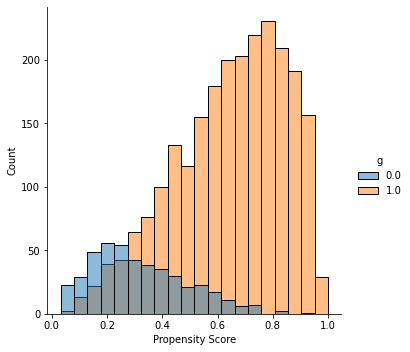

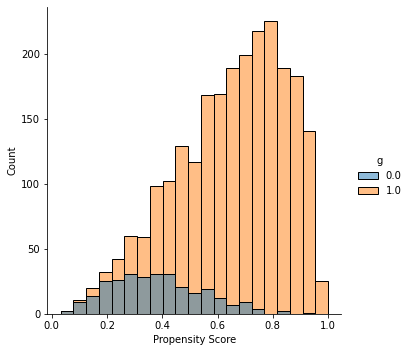

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.046,0.993,0.631
1,clsize,0.255,1.454,1.126,0.262
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.563,1.188,1.257
4,hedres,0.199,0.292,0.868,0.913
5,heduc,0.297,0.329,1.077,0.897
6,hisei,0.511,0.617,1.207,1.215
7,homepos,0.393,0.484,1.100,0.985
8,ictres,0.225,0.251,1.032,0.923
9,immig,0.008,0.000,0.991,0.953


FRA  MATH
Estimate: 0.923, Standard Error: 0.039, p-value: 0.0
FRA  SCIENCE
Estimate: 1.044, Standard Error: 0.042, p-value: 0.0
FRA  READING
Estimate: 1.054, Standard Error: 0.031, p-value: 0.0
-------------------------------
GRC
-------------------------------
(3428, 187)
Total number of observations: 3428, of which 3168 treated and 260 are controls


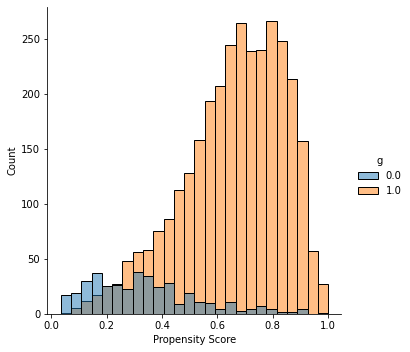

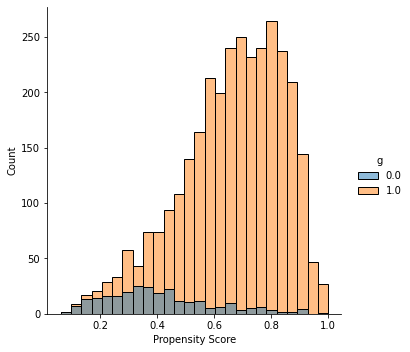

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.077,0.993,0.641
1,clsize,0.255,0.623,1.126,2.305
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.430,1.188,0.826
4,hedres,0.199,0.405,0.868,0.991
5,heduc,0.297,0.410,1.077,0.748
6,hisei,0.511,0.583,1.207,1.439
7,homepos,0.393,0.525,1.100,1.032
8,ictres,0.225,0.149,1.032,0.866
9,immig,0.008,0.323,0.991,0.447


GRC  MATH
Estimate: 0.993, Standard Error: 0.052, p-value: 0.0
GRC  SCIENCE
Estimate: 0.965, Standard Error: 0.05, p-value: 0.0
GRC  READING
Estimate: 1.092, Standard Error: 0.038, p-value: 0.0
-------------------------------
HRV
-------------------------------
(1984, 187)
Total number of observations: 1984, of which 1421 treated and 563 are controls


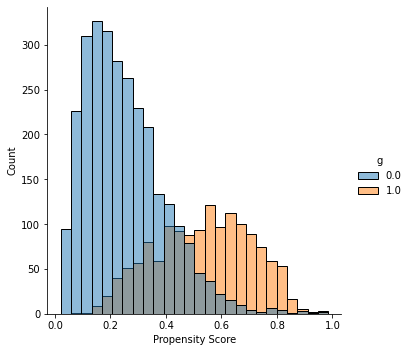

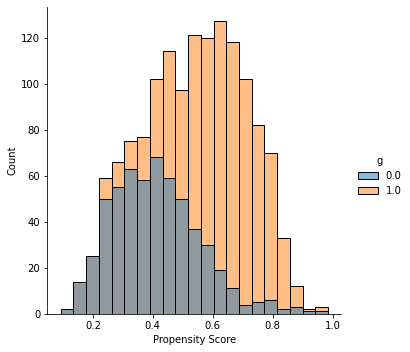

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.140,0.993,0.975
1,clsize,0.255,0.580,1.126,2.447
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.175,1.188,1.134
4,hedres,0.199,0.224,0.868,1.065
5,heduc,0.297,0.152,1.077,0.985
6,hisei,0.511,0.245,1.207,0.975
7,homepos,0.393,0.232,1.100,0.989
8,ictres,0.225,0.235,1.032,0.872
9,immig,0.008,0.110,0.991,0.688


HRV  MATH
Estimate: 0.74, Standard Error: 0.044, p-value: 0.0
HRV  SCIENCE
Estimate: 0.743, Standard Error: 0.039, p-value: 0.0
HRV  READING
Estimate: 0.746, Standard Error: 0.03, p-value: 0.0
-------------------------------
HUN
-------------------------------
(1976, 187)
Total number of observations: 1976, of which 1380 treated and 596 are controls


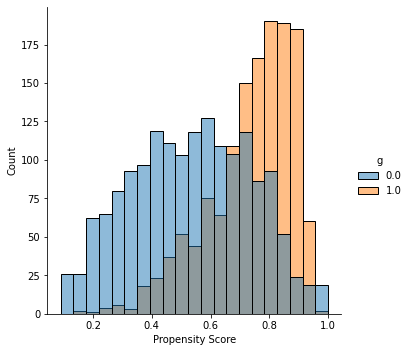

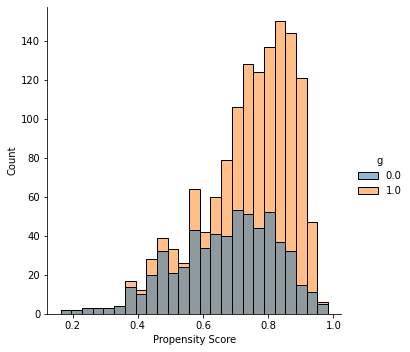

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.107,0.993,0.836
1,clsize,0.255,0.022,1.126,0.569
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.395,1.188,1.187
4,hedres,0.199,0.309,0.868,0.947
5,heduc,0.297,0.421,1.077,0.698
6,hisei,0.511,0.467,1.207,0.928
7,homepos,0.393,0.484,1.100,0.832
8,ictres,0.225,0.281,1.032,0.892
9,immig,0.008,0.026,0.991,1.168


HUN  MATH
Estimate: 0.779, Standard Error: 0.04, p-value: 0.0
HUN  SCIENCE
Estimate: 0.849, Standard Error: 0.041, p-value: 0.0
HUN  READING
Estimate: 0.854, Standard Error: 0.033, p-value: 0.0
-------------------------------
ITA
-------------------------------
(3735, 187)
Total number of observations: 3735, of which 2650 treated and 1085 are controls


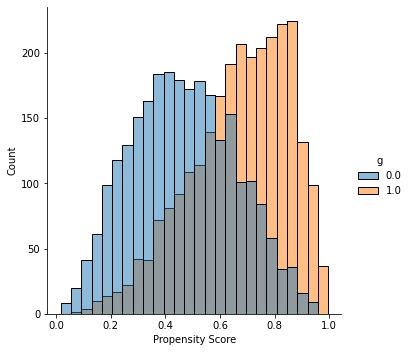

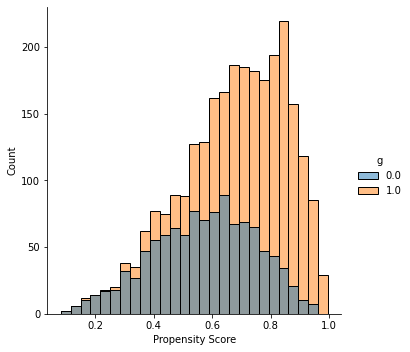

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.172,0.993,0.785
1,clsize,0.255,0.095,1.126,0.615
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.387,1.188,0.790
4,hedres,0.199,0.178,0.868,0.831
5,heduc,0.297,0.166,1.077,0.981
6,hisei,0.511,0.315,1.207,1.076
7,homepos,0.393,0.331,1.100,0.934
8,ictres,0.225,0.116,1.032,0.899
9,immig,0.008,0.190,0.991,0.486


ITA  MATH
Estimate: 0.575, Standard Error: 0.047, p-value: 0.0
ITA  SCIENCE
Estimate: 0.57, Standard Error: 0.046, p-value: 0.0
ITA  READING
Estimate: 0.71, Standard Error: 0.039, p-value: 0.0
-------------------------------
LTU
-------------------------------
(46, 187)
Total number of observations: 46, of which 26 treated and 20 are controls


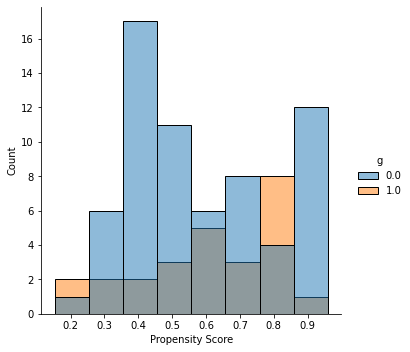

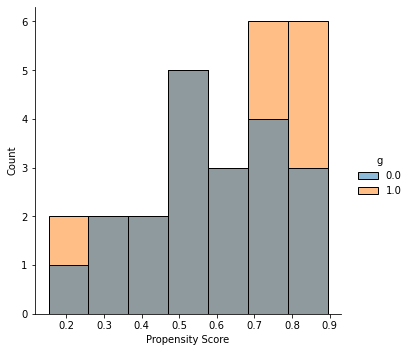

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.186,0.993,2.466
1,clsize,0.255,0.233,1.126,0.497
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.016,1.188,2.124
4,hedres,0.199,0.030,0.868,0.759
5,heduc,0.297,0.747,1.077,0.709
6,hisei,0.511,0.715,1.207,1.389
7,homepos,0.393,0.532,1.100,1.312
8,ictres,0.225,0.373,1.032,0.996
9,immig,0.008,0.316,0.991,0.000


LTU  MATH
Estimate: 0.373, Standard Error: 0.202, p-value: 0.0
LTU  SCIENCE
Estimate: 0.287, Standard Error: 0.225, p-value: 0.20107734483052164
LTU  READING
Estimate: 0.242, Standard Error: 0.209, p-value: 0.24697730533366835
-------------------------------
LUX
-------------------------------
(793, 187)
Total number of observations: 793, of which 667 treated and 126 are controls


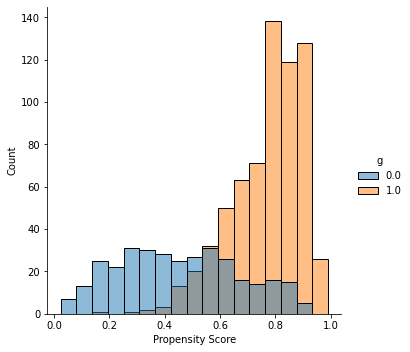

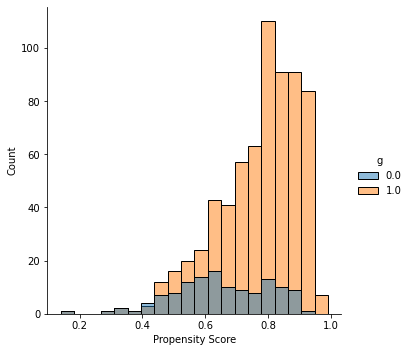

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.097,0.993,0.538
1,clsize,0.255,0.692,1.126,0.135
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.376,1.188,0.795
4,hedres,0.199,0.123,0.868,0.642
5,heduc,0.297,0.407,1.077,0.478
6,hisei,0.511,0.621,1.207,0.853
7,homepos,0.393,0.414,1.100,0.954
8,ictres,0.225,0.196,1.032,1.014
9,immig,0.008,0.264,0.991,0.873


LUX  MATH
Estimate: 0.816, Standard Error: 0.052, p-value: 0.0
LUX  SCIENCE
Estimate: 0.777, Standard Error: 0.049, p-value: 0.0
LUX  READING
Estimate: 0.727, Standard Error: 0.044, p-value: 0.0
-------------------------------
MNE
-------------------------------
(2744, 187)
Total number of observations: 2744, of which 1784 treated and 960 are controls


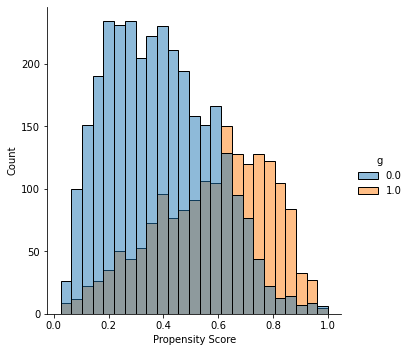

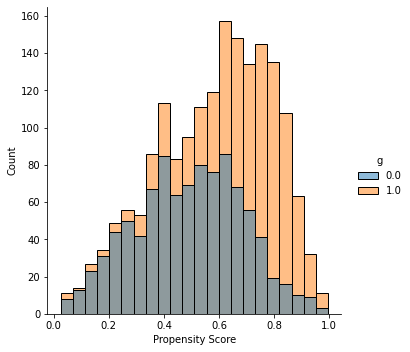

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.090,0.993,0.968
1,clsize,0.255,0.310,1.126,0.844
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.145,1.188,1.093
4,hedres,0.199,0.169,0.868,1.016
5,heduc,0.297,0.101,1.077,1.078
6,hisei,0.511,0.168,1.207,1.035
7,homepos,0.393,0.093,1.100,0.882
8,ictres,0.225,0.037,1.032,0.934
9,immig,0.008,0.070,0.991,0.683


MNE  MATH
Estimate: 0.575, Standard Error: 0.029, p-value: 0.0
MNE  SCIENCE
Estimate: 0.587, Standard Error: 0.032, p-value: 0.0
MNE  READING
Estimate: 0.626, Standard Error: 0.02, p-value: 0.0
-------------------------------
PRT
-------------------------------
(2553, 187)
Total number of observations: 2553, of which 2188 treated and 365 are controls


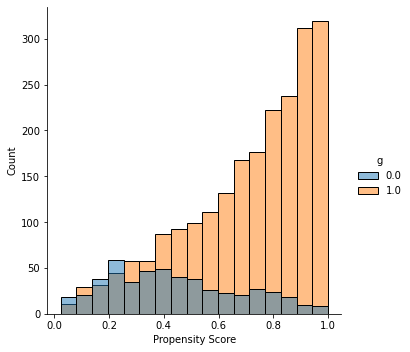

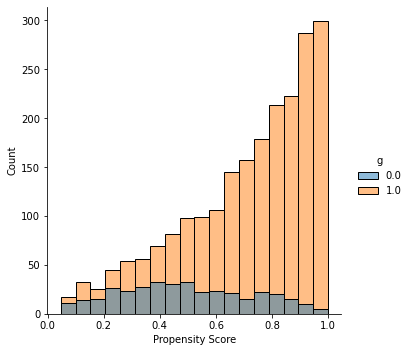

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.111,0.993,0.674
1,clsize,0.255,0.402,1.126,0.604
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.328,1.188,0.792
4,hedres,0.199,0.274,0.868,0.938
5,heduc,0.297,0.452,1.077,0.697
6,hisei,0.511,0.462,1.207,0.989
7,homepos,0.393,0.425,1.100,0.776
8,ictres,0.225,0.239,1.032,0.804
9,immig,0.008,0.003,0.991,0.942


PRT  MATH
Estimate: 0.785, Standard Error: 0.046, p-value: 0.0
PRT  SCIENCE
Estimate: 0.778, Standard Error: 0.036, p-value: 0.0
PRT  READING
Estimate: 0.745, Standard Error: 0.038, p-value: 0.0
-------------------------------
ROU
-------------------------------
(2079, 187)
Total number of observations: 2079, of which 1896 treated and 183 are controls


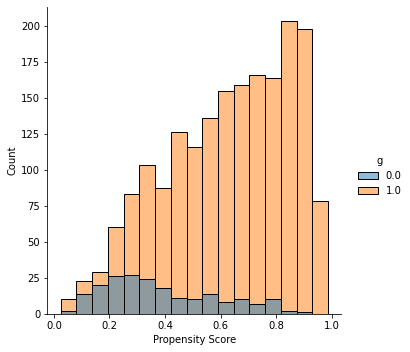

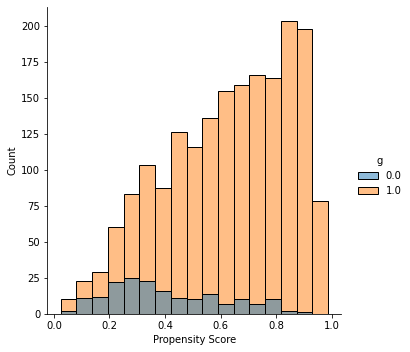

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.085,0.993,0.567
1,clsize,0.255,0.135,1.126,0.361
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.780,1.188,1.868
4,hedres,0.199,0.827,0.868,0.667
5,heduc,0.297,0.515,1.077,0.754
6,hisei,0.511,0.781,1.207,2.095
7,homepos,0.393,0.854,1.100,0.913
8,ictres,0.225,0.457,1.032,0.723
9,immig,0.008,0.039,0.991,2.881


ROU  MATH
Estimate: 1.033, Standard Error: 0.068, p-value: 0.0
ROU  SCIENCE
Estimate: 0.91, Standard Error: 0.064, p-value: 0.0
ROU  READING
Estimate: 1.111, Standard Error: 0.059, p-value: 0.0
-------------------------------
SRB
-------------------------------
(3084, 187)
Total number of observations: 3084, of which 2288 treated and 796 are controls


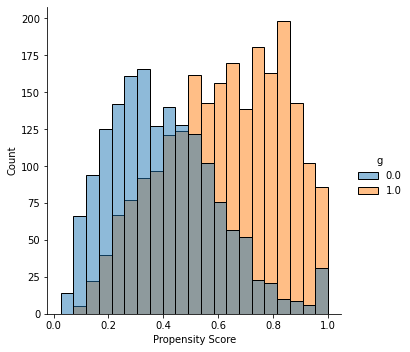

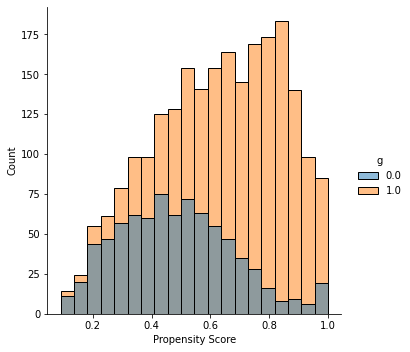

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.210,0.993,0.798
1,clsize,0.255,0.375,1.126,1.359
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.241,1.188,0.923
4,hedres,0.199,0.224,0.868,0.907
5,heduc,0.297,0.280,1.077,0.982
6,hisei,0.511,0.463,1.207,1.084
7,homepos,0.393,0.340,1.100,0.981
8,ictres,0.225,0.249,1.032,1.046
9,immig,0.008,0.055,0.991,0.814


SRB  MATH
Estimate: 0.628, Standard Error: 0.042, p-value: 0.0
SRB  SCIENCE
Estimate: 0.598, Standard Error: 0.038, p-value: 0.0
SRB  READING
Estimate: 0.748, Standard Error: 0.034, p-value: 0.0
-------------------------------
SVK
-------------------------------
(1555, 187)
Total number of observations: 1555, of which 1434 treated and 121 are controls


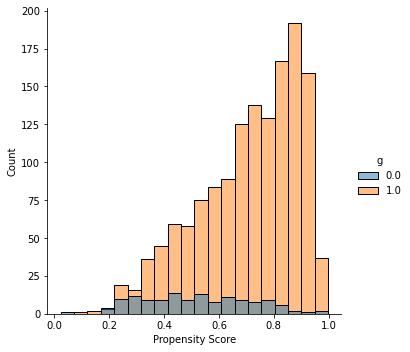

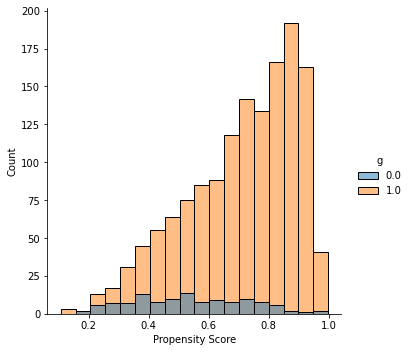

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.525,0.993,0.454
1,clsize,0.255,0.828,1.126,1.823
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.513,1.188,1.548
4,hedres,0.199,0.722,0.868,0.652
5,heduc,0.297,0.506,1.077,1.192
6,hisei,0.511,0.899,1.207,1.624
7,homepos,0.393,0.804,1.100,0.924
8,ictres,0.225,0.593,1.032,0.683
9,immig,0.008,0.013,0.991,2.015


SVK  MATH
Estimate: 1.359, Standard Error: 0.083, p-value: 0.0
SVK  SCIENCE
Estimate: 1.226, Standard Error: 0.073, p-value: 0.0
SVK  READING
Estimate: 1.147, Standard Error: 0.063, p-value: 0.0
-------------------------------
SVN
-------------------------------
(1606, 187)
Total number of observations: 1606, of which 1019 treated and 587 are controls


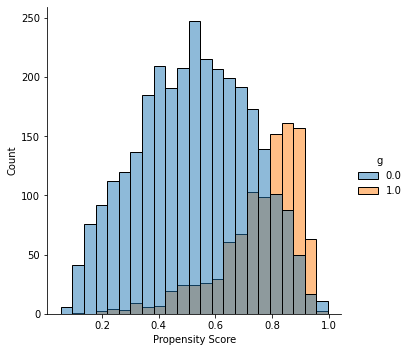

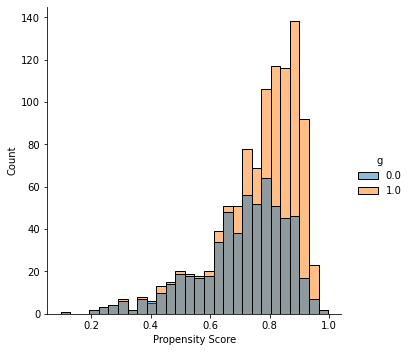

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.115,0.993,0.816
1,clsize,0.255,0.016,1.126,1.511
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.128,1.188,0.922
4,hedres,0.199,0.105,0.868,1.077
5,heduc,0.297,0.287,1.077,0.867
6,hisei,0.511,0.290,1.207,0.866
7,homepos,0.393,0.181,1.100,0.875
8,ictres,0.225,0.139,1.032,0.813
9,immig,0.008,0.142,0.991,0.525


SVN  MATH
Estimate: 0.781, Standard Error: 0.03, p-value: 0.0
SVN  SCIENCE
Estimate: 0.693, Standard Error: 0.03, p-value: 0.0
SVN  READING
Estimate: 0.717, Standard Error: 0.032, p-value: 0.0
-------------------------------
TUR
-------------------------------
(5464, 187)
Total number of observations: 5464, of which 4154 treated and 1310 are controls


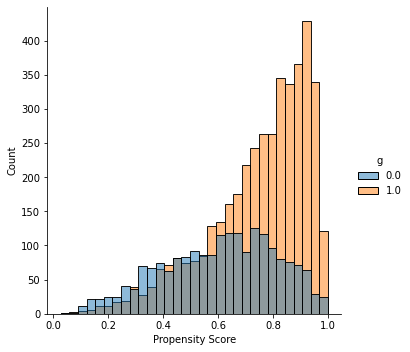

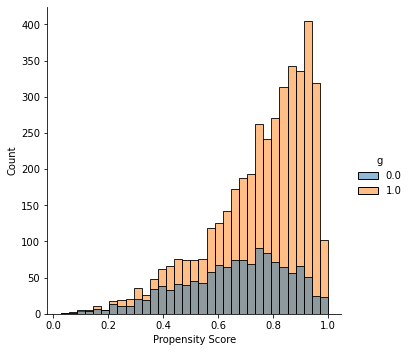

<ipython-input-130-552287057cf0>:24: RuntimeWarning: invalid value encountered in scalar divide
  smd = round((np.abs(mean_treatment - mean_control) / pooled_std),3)
<ipython-input-131-5cd784a08d2f>:18: RuntimeWarning: invalid value encountered in scalar divide
  variance_ratio = round((var_treatment / var_control),3)


,variables,SMDpre,SMDpost,VRpre,VRpost
0,age_elementary,0.022,0.010,0.993,0.789
1,clsize,0.255,0.040,1.126,1.048
2,cntryid,0.290,NaN,0.947,NaN
3,cultposs,0.348,0.182,1.188,1.279
4,hedres,0.199,0.131,0.868,1.044
5,heduc,0.297,0.198,1.077,1.191
6,hisei,0.511,0.343,1.207,1.584
7,homepos,0.393,0.233,1.100,1.436
8,ictres,0.225,0.138,1.032,1.235
9,immig,0.008,0.035,0.991,2.020


TUR  MATH
Estimate: 0.786, Standard Error: 0.026, p-value: 0.0
TUR  SCIENCE
Estimate: 0.752, Standard Error: 0.026, p-value: 0.0
TUR  READING
Estimate: 0.712, Standard Error: 0.025, p-value: 0.0


In [151]:
#Analysis by country
for country in dfa['cnt'].unique():
    
    print('-------------------------------')
    print(country)
    print('-------------------------------')
        
    df_cnt = dfa[dfa['cnt']==country].copy()
    
    if len(df_cnt[df_cnt['g'] == 1])== 0 or len(df_cnt[df_cnt['g'] == 0])==0:
        print('Not enough observations to conduct the analysis')             
              
    else:
        
        df_cnt['ps_cnt'] = lr.predict_proba(df_cnt[covariates])[:,1]

        matched_cnt = PSMatch(df_cnt, 'g', 'ps_cnt')

        print(matched_cnt.shape)

        a, b, c = len(matched_cnt), len(matched_cnt[matched_cnt['g'] == 1]), len(matched_cnt[matched_cnt['g'] == 0])

        '''
        if a == 0 or b == 0 or c == 0:
            print('Not enough observations to conduct the analysis')



        else: '''               
        print(f'Total number of observations: {a}, of which {b} treated and {c} are controls')

        PSPlot( df_cnt,'g', 'ps_cnt')

        PSPlot(matched_cnt, 'g', 'ps_cnt')

        B = AssessBalance(df, matched_cnt, 'g', covariates)
        display(B)

        for subject in [pv_math, pv_scie, pv_read]:      
            if subject == pv_math:
                print(country, ' MATH')
                PisaEstimate(matched_cnt, subject, rep_weights, 'w_fstuwt', 'g', MeanComparison)
            elif subject == pv_scie:
                print(country, ' SCIENCE')
                PisaEstimate(matched_cnt, subject, rep_weights, 'w_fstuwt', 'g', MeanComparison)
            else:
                print(country, ' READING')
                PisaEstimate(matched_cnt, subject, rep_weights, 'w_fstuwt', 'g', MeanComparison)



### Summay Table of countries results:
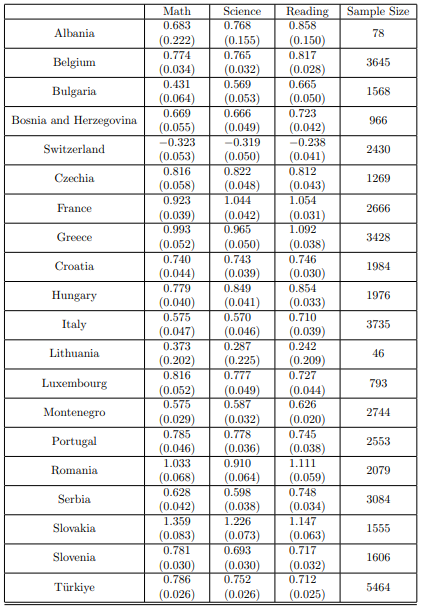